# Experiment 6: Position-Dependent Temperature (Updated)

**Goal:** Test position-dependent α decay and dynamic T*(t)

**New formula:** $T^*(t) = T_{base} \times (1 + \alpha(t))$

**Hypothesis:** α decreases with position due to:
1. Averaging effect in attention
2. LayerNorm dissipation

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.optimize import curve_fit

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Imports loaded!")

Imports loaded!


In [6]:
# ============================================================
# LOAD MODEL
# ============================================================

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
T_BASE = 0.8  # Optimal temperature for clean model

print(f"Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map="auto"
)
model.eval()
print(f"Model loaded on {model.device}")
print(f"T_base = {T_BASE}")

Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...
Model loaded on cuda:0
T_base = 0.8


In [7]:
# ============================================================
# NOISE INJECTION UTILITIES (FIXED)
# ============================================================

def add_activation_noise(model, noise_scale):
    """Add noise to all linear layer activations."""
    handles = []
    
    def make_hook(scale):
        def hook(module, args):
            # forward_pre_hook receives (module, args)
            # should return None or modified args tuple
            if len(args) > 0 and args[0] is not None:
                inp = args[0]
                noise = torch.randn_like(inp) * scale * inp.std()
                new_inp = inp + noise
                return (new_inp,) + args[1:]
            return None
        return hook
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            h = module.register_forward_pre_hook(make_hook(noise_scale))
            handles.append(h)
    
    return handles


def remove_hooks(handles):
    for h in handles:
        h.remove()


def get_position_alpha(model, tokenizer, prompt, noise_scale, num_samples=5):
    """
    Measure α at each token position during generation.
    Returns: list of α values, one per position.
    """
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    
    # Get clean logits for all positions
    with torch.no_grad():
        clean_outputs = model(inputs.input_ids)
    clean_logits = clean_outputs.logits[0]  # [seq_len, vocab]
    
    # Get noisy logits
    all_alphas = [[] for _ in range(clean_logits.shape[0])]
    
    for _ in range(num_samples):
        handles = add_activation_noise(model, noise_scale)
        try:
            with torch.no_grad():
                noisy_outputs = model(inputs.input_ids)
            noisy_logits = noisy_outputs.logits[0]
            
            # Compute α for each position
            for pos in range(clean_logits.shape[0]):
                diff = noisy_logits[pos] - clean_logits[pos]
                tau_sq = clean_logits[pos].var().item()
                sigma_sq = diff.var().item()
                alpha = sigma_sq / tau_sq if tau_sq > 0 else 0
                all_alphas[pos].append(alpha)
        finally:
            remove_hooks(handles)
    
    # Average over samples
    return [np.mean(a) for a in all_alphas]

print("Utilities ready!")

Utilities ready!


In [8]:
# ============================================================
# MEASURE α(t) DECAY
# ============================================================

test_prompt = """Solve this step by step:
A store has 50 apples. They sell 20 apples in the morning and receive 30 more in the afternoon. How many apples do they have now?

Let me think through this carefully:"""

NOISE_SCALE = 0.05

print(f"Measuring α at each position (noise σ = {NOISE_SCALE})...")
print("This may take a few minutes...")

alpha_by_position = get_position_alpha(model, tokenizer, test_prompt, NOISE_SCALE, num_samples=10)

print(f"\nMeasured α for {len(alpha_by_position)} positions")
print(f"First 5 positions: {[f'{a:.4f}' for a in alpha_by_position[:5]]}")
print(f"Last 5 positions: {[f'{a:.4f}' for a in alpha_by_position[-5:]]}")

Measuring α at each position (noise σ = 0.05)...
This may take a few minutes...

Measured α for 50 positions
First 5 positions: ['0.0050', '0.2079', '0.1125', '0.1272', '0.2394']
Last 5 positions: ['0.1138', '0.1034', '0.1019', '0.1140', '0.1066']


In [9]:
# ============================================================
# COMPUTE T*(t) WITH NEW FORMULA
# ============================================================

# New formula: T*(t) = T_base × (1 + α(t))
t_star_new = [T_BASE * (1 + a) for a in alpha_by_position]

# Old formula: T*(t) = T_base × √(1 + α(t))
t_star_old = [T_BASE * np.sqrt(1 + a) for a in alpha_by_position]

# Constant T* (using mean α)
mean_alpha = np.mean(alpha_by_position)
t_star_const_new = T_BASE * (1 + mean_alpha)
t_star_const_old = T_BASE * np.sqrt(1 + mean_alpha)

print(f"Mean α = {mean_alpha:.4f}")
print(f"\nConstant T* (new): {t_star_const_new:.4f}")
print(f"Constant T* (old): {t_star_const_old:.4f}")

Mean α = 0.1462

Constant T* (new): 0.9170
Constant T* (old): 0.8565


In [10]:
# ============================================================
# FIT α(t) FUNCTION
# ============================================================

positions = np.arange(len(alpha_by_position))
alpha_arr = np.array(alpha_by_position)

# Candidate functions
def exponential_decay(t, a, b, c):
    """α(t) = a × exp(-b×t) + c"""
    return a * np.exp(-b * t) + c

def inverse_linear(t, a, b):
    """α(t) = a / (t + b)"""
    return a / (t + b + 1e-6)

def inverse_sqrt(t, a, b, c):
    """α(t) = a / √(t + b) + c"""
    return a / np.sqrt(t + b + 1e-6) + c

# Fit functions
fits = {}

try:
    popt, _ = curve_fit(exponential_decay, positions, alpha_arr, p0=[0.3, 0.01, 0.1], maxfev=5000)
    pred = exponential_decay(positions, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['exponential'] = {'params': popt, 'mse': mse, 'func': exponential_decay,
                           'formula': f'α(t) = {popt[0]:.4f} × exp(-{popt[1]:.4f}×t) + {popt[2]:.4f}'}
except Exception as e:
    print(f"Exponential fit failed: {e}")

try:
    popt, _ = curve_fit(inverse_linear, positions, alpha_arr, p0=[1, 1], maxfev=5000)
    pred = inverse_linear(positions, *popt)
    mse = np.mean((alpha_arr - pred)**2)
    fits['inverse_linear'] = {'params': popt, 'mse': mse, 'func': inverse_linear,
                              'formula': f'α(t) = {popt[0]:.4f} / (t + {popt[1]:.2f})'}
except Exception as e:
    print(f"Inverse linear fit failed: {e}")

# Print results
print("="*70)
print("FIT RESULTS")
print("="*70)
print(f"{'Function':<20} {'MSE':<15} {'Formula'}")
print("-"*70)

best_name = None
best_mse = float('inf')
for name, fit in fits.items():
    print(f"{name:<20} {fit['mse']:<15.6f} {fit['formula']}")
    if fit['mse'] < best_mse:
        best_mse = fit['mse']
        best_name = name

print(f"\nBest fit: {best_name}")
best_fit = fits[best_name]

FIT RESULTS
Function             MSE             Formula
----------------------------------------------------------------------
exponential          0.007065        α(t) = 0.0766 × exp(-0.0522×t) + 0.1183
inverse_linear       0.007084        α(t) = 15.4605 / (t + 83.25)

Best fit: exponential


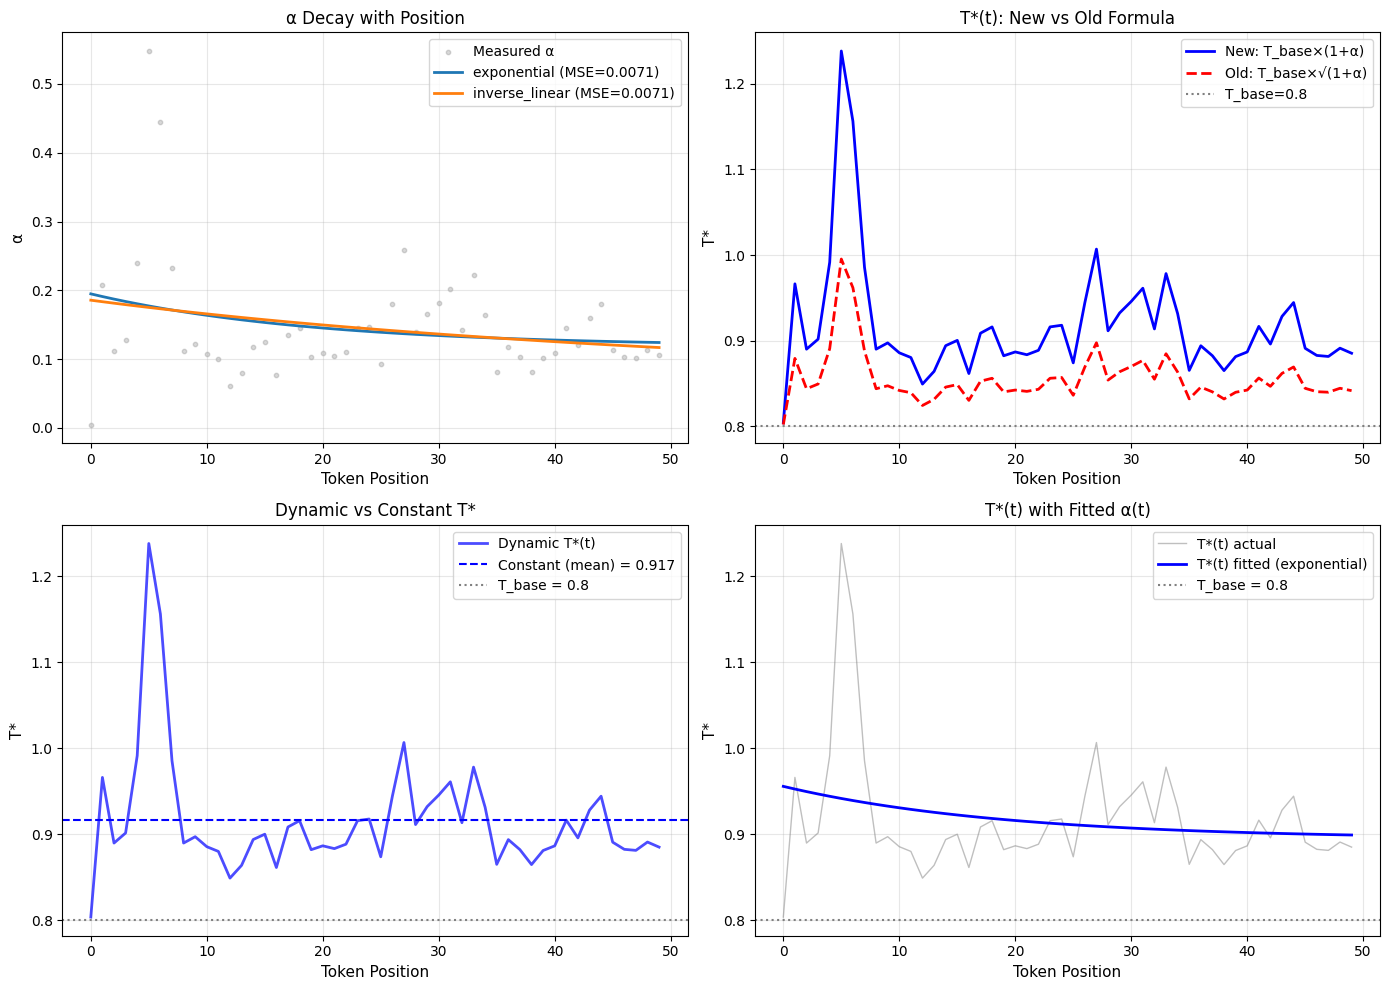

In [11]:
# ============================================================
# PLOT RESULTS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: α(t) decay
ax1 = axes[0, 0]
ax1.scatter(positions, alpha_arr, alpha=0.3, s=10, color='gray', label='Measured α')
for name, fit in fits.items():
    pred = fit['func'](positions, *fit['params'])
    ax1.plot(positions, pred, linewidth=2, label=f"{name} (MSE={fit['mse']:.4f})")
ax1.set_xlabel('Token Position', fontsize=11)
ax1.set_ylabel('α', fontsize=11)
ax1.set_title('α Decay with Position', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top right: T*(t) new vs old formula
ax2 = axes[0, 1]
ax2.plot(positions, t_star_new, 'b-', linewidth=2, label='New: T_base×(1+α)')
ax2.plot(positions, t_star_old, 'r--', linewidth=2, label='Old: T_base×√(1+α)')
ax2.axhline(y=T_BASE, color='gray', linestyle=':', label=f'T_base={T_BASE}')
ax2.set_xlabel('Token Position', fontsize=11)
ax2.set_ylabel('T*', fontsize=11)
ax2.set_title('T*(t): New vs Old Formula', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom left: Dynamic vs constant T*
ax3 = axes[1, 0]
ax3.plot(positions, t_star_new, 'b-', linewidth=2, alpha=0.7, label='Dynamic T*(t)')
ax3.axhline(y=t_star_const_new, color='blue', linestyle='--', label=f'Constant (mean) = {t_star_const_new:.3f}')
ax3.axhline(y=T_BASE, color='gray', linestyle=':', label=f'T_base = {T_BASE}')
ax3.set_xlabel('Token Position', fontsize=11)
ax3.set_ylabel('T*', fontsize=11)
ax3.set_title('Dynamic vs Constant T*', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Bottom right: T*(t) with fitted α(t)
ax4 = axes[1, 1]
alpha_fitted = best_fit['func'](positions, *best_fit['params'])
t_star_fitted = T_BASE * (1 + alpha_fitted)  # Using NEW formula
ax4.plot(positions, t_star_new, 'gray', linewidth=1, alpha=0.5, label='T*(t) actual')
ax4.plot(positions, t_star_fitted, 'b-', linewidth=2, label=f'T*(t) fitted ({best_name})')
ax4.axhline(y=T_BASE, color='gray', linestyle=':', label=f'T_base = {T_BASE}')
ax4.set_xlabel('Token Position', fontsize=11)
ax4.set_ylabel('T*', fontsize=11)
ax4.set_title('T*(t) with Fitted α(t)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('position_dependent_temperature.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# ============================================================
# SUMMARY
# ============================================================

print("="*70)
print("SUMMARY: Position-Dependent Temperature")
print("="*70)

print(f"""
NEW FORMULA: T*(t) = T_base × (1 + α(t))

Fitted α(t):
  {best_fit['formula']}

Key findings:
  - α decreases with position (noise dissipates)
  - Early tokens: α ≈ {alpha_arr[0]:.4f}, T* ≈ {t_star_new[0]:.3f}
  - Late tokens:  α ≈ {alpha_arr[-1]:.4f}, T* ≈ {t_star_new[-1]:.3f}
  - Mean α = {mean_alpha:.4f}
  
Practical recommendation:
  - Use dynamic T*(t) for best results
  - Or use constant T* = {t_star_const_new:.3f} as approximation
  - T_base = {T_BASE} for this model
""")

# Thermal analogy
if best_name == 'exponential':
    a, b, c = best_fit['params']
    tau = 1/b  # Time constant
    half_life = tau * np.log(2)
    print(f"Thermal analogy:")
    print(f"  α₀ = {a+c:.4f} (initial noise)")
    print(f"  α∞ = {c:.4f} (residual floor)")
    print(f"  τ = {tau:.1f} tokens (time constant)")
    print(f"  Half-life = {half_life:.1f} tokens")

SUMMARY: Position-Dependent Temperature

NEW FORMULA: T*(t) = T_base × (1 + α(t))

Fitted α(t):
  α(t) = 0.0766 × exp(-0.0522×t) + 0.1183

Key findings:
  - α decreases with position (noise dissipates)
  - Early tokens: α ≈ 0.0050, T* ≈ 0.804
  - Late tokens:  α ≈ 0.1066, T* ≈ 0.885
  - Mean α = 0.1462
  
Practical recommendation:
  - Use dynamic T*(t) for best results
  - Or use constant T* = 0.917 as approximation
  - T_base = 0.8 for this model

Thermal analogy:
  α₀ = 0.1949 (initial noise)
  α∞ = 0.1183 (residual floor)
  τ = 19.2 tokens (time constant)
  Half-life = 13.3 tokens
